# Term1 Sprint13 授業課題 
## コーディング課題：畳み込みニューラルネットワーク(CNN)スクラッチ2

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していく。

Sprint12では1次元畳み込み層を実装したが、Sprint13では画像に対して一般的に使われる2次元畳み込み層を実装する。  
また、プーリング層なども作成することで、CNNの基本形を完成させる。  

**データセットの用意**  
引き続きMNISTデータセットを使用する。2次元畳み込み層へは、28×28の状態で入力する。

今回は白黒画像であるからチャンネルは1つしかないが、チャンネル方向の軸は用意しておく必要がある。

(n_samples, n_channels, height, width)のNCHWまたは(n_samples, height, width, n_channels)のNHWCどちらかの形にする。

**CNN分類器クラスの作成**  
2次元畳み込みニューラルネットワークモデルのクラスScratch2dCNNClassifierを作成する。

## 1. 2次元畳み込み層の作成
Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成する。  

フォワードプロパゲーションの数式は以下のようになる。
$$a_{i,j,m} = \sum_{k=0}^{K-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1}x_{(i+s),(j+t),k}w_{s,t,k,m}+b_{m}$$

$a_{i,j,m}$ : 出力される配列の$i$行j列、$m$チャンネルの値  
$i$ : 配列の行方向のインデックス  
$j$ : 配列の列方向のインデックス  
$m$ : 出力チャンネルのインデックス  
$K$ : 入力チャンネル数  
$F_h,F_w$ : 高さ方向$(h)$と幅方向$(w)$のフィルタのサイズ  
$x_{(i+s),(j+t),k}$ : 入力の配列の$(i+s)$行$(j+t)$列、$k$チャンネルの値  
$w_{s,t,k,m}$ : 重みの配列の$s$行$t$列目。$k$チャンネルの入力に対して、$m$チャンネルへ出力する重み  
$b_m$ : $m$チャンネルへの出力のバイアス項  

全てスカラー量となる。

次に更新式は、1次元畳み込み層や全結合層と同じ形である。
$$w_{s,t,k,m}^{\prime} = w_{s,t,k,m} - \alpha \frac{\partial L}{\partial w_{s,t,k,m}}$$

$$b_{m}^{\prime} = b_{m} - \alpha \frac{\partial L}{\partial b_{m}}$$

$\alpha$ : 学習率  
$\frac{\partial L}{\partial w_{s,t,k,m}}$ : $w_{s,t,k,m}$に関する損失$L$の勾配  
$\frac{\partial L}{\partial b_m}$ : $b_m$に関する損失$L$の勾配  
勾配$\frac{\partial L}{\partial w_{s,t,k,m}}$や$\frac{\partial L}{\partial b_m}$を求めるためのバックプロパゲーションの数式は以下の通り。

$$\frac{\partial L}{\partial w_{s,t,k,m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1} \frac{\partial L}{\partial a_{i,j,m}}x_{(i+s)(j+t),k}$$

$$\frac{\partial L}{\partial b_{m}} = \sum_{i=0}^{N_{out,h}-1}\sum_{j=0}^{N_{out,w}-1}\frac{\partial L}{\partial a_{i,j,m}}$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列の$i$行$j$列、$m$チャンネルの値  
$N_{out,h},N_{out,w}$ : 高さ方向$（h）$と幅方向$（w）$の出力のサイズ  

前の層に流す誤差の数式は以下の通り。
$$\frac{\partial L}{\partial x_{i,j,k}} = \sum_{m=0}^{M-1}\sum_{s=0}^{F_{h}-1}\sum_{t=0}^{F_{w}-1} \frac{\partial L}{\partial a_{(i-s),(j-t),m}}w_{s,t,k,m}$$

$\frac{\partial L}{\partial x_{i,j,k}}$ : 前の層に流す誤差の配列の$i$列$j$行、$k$チャンネルの値  
$M$ : 出力チャンネル数  

ただし、$i-s<0$または$i-s>N_{out,h}-1$または$j-t<0$または$j-t>N_{out,w}-1$のとき$\frac{\partial L}{\partial a_{(i-s),(j-t),m}}=0$となる。

## 2. 2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化する。  
どのように変化するかは以下の数式から求められる。この計算を行う関数を作成する。

$$N_{h,out}=\frac{N_{h,in}+2P_{h}-F_{h}}{S_{h}}+1$$

$$N_{w,out}=\frac{N_{w,in}+2P_{w}-F_{w}}{S_{w}}+1$$

$N_{out}$ : 出力のサイズ（特徴量の数）  
$N_{in}$ : 入力のサイズ（特徴量の数）  
$P$ : ある方向へのパディングの数  
$F$ : フィルタのサイズ  
$S$ : ストライドのサイズ  
$h$が高さ方向、$w$が幅方向である。

## 3. 最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成する。  
プーリング層は数式で表さない方が分かりやすい部分もあるが、フォワードプロパゲーションの数式は以下のようになる。

$$a_{i,j,k} = \max_{(p,q)\in P_{i,j}}x_{p,q,k}$$

$P_{i,j}$ : $i$行$j$列へ出力する場合の入力配列のインデックスの集合。$S_h*S_w$の範囲内の行$（p）$と列$（q）$  
$S_h,S_w$ : 高さ方向$（h）$と幅方向$（w）$のストライドのサイズ  
$(p,q) \in P_{i,j}$ : $P_{i,j}$に含まれる行$（p）$と列$（q）$のインデックス  
$a_{i,j,m}$ : 出力される配列の$i$行$j$列、$k$チャンネルの値  
$x_{p,q,k}$ : 入力の配列の$p$行$q$列、$k$チャンネルの値  

ある範囲の中でチャンネル方向の軸は残したまま最大値を計算することになる。

バックプロパゲーションのためには、フォワードプロパゲーションのときの最大値のインデックス$(p,q)$を保持しておく必要がある。  
フォワード時に最大値を持っていた箇所にそのままの誤差を流し、そこ以外には$0$を入れるためである。


## 4. 平滑化
平滑化するためのクラスFlatten()を作成する。

フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeする。  
その値は記録しておき、バックワードのときに再びreshapeによって形を戻す。

## 5. 学習・推定
作成したConv2dを使用してMNISTの分類を学習・推定する。

この段階では精度は気にせず、まずは動くことを確認する。

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyprind
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# データ生成
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# (n_samples, n_channels, height, width)のNCHWに次元整形
# 今回はモノクロなのでチャンネル数は1
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 訓練データから更に検証データを生成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print("X_train.shape: ", X_train.shape)
print("X_val.shape: ", X_val.shape)
print("y_train.shape: ", y_train.shape)
print("y_val.shape: ", y_val.shape)

X_train.shape:  (48000, 1, 28, 28)
X_val.shape:  (12000, 1, 28, 28)
y_train.shape:  (48000,)
y_val.shape:  (12000,)


分類器のインスタンス生成時に各種パラメータを汎用的に選択できるように、最適化手法クラスや活性化関数クラスは一般化している。  

**作成クラス、関数一覧**
- class Scratch2dCNNClassifier
- class Conv2dLayer
- class MaxPool2dLayer
- def im2col
- def col2im
- class Flatten
- class FullConnLayer
- class LearningMethod
- class SimpleInitializer
- class Activator
- class Softmax
- class GetMiniBatch

In [12]:
class Scratch2dCNNClassifier:
    """
    大枠で5層のCNN分類器
    ----------
    - 畳み込み隠れ層
    - 最大プーリング層
    - 全結合隠れ層1
    - 全結合隠れ層2
    - 全結合出力層
    
    生成インスタンス一覧 (Forward昇順)
    ----------
    - Conv2dLayer
    - Activator
    - MaxPool2dLayer
    - Flatten
    - FullConnLayer
    - Activator
    - FullConnLayer
    - Activator
    - FullConnLayer
    - Softmax    

    Parameters
    ----------
    FN (Filter Number) : int
        畳み込み隠れ層の出力チャンネル数（フィルターの個数）
    C(Channels) : int
        畳み込み隠れ層の入力チャンネル数
    FS(Filter Size) : int
        畳み込み隠れ層のフィルターの一辺の要素数 (長さ)
    S(Stride) : int
        畳み込み隠れ層のストライド数
    P(Padding) : int
        畳み込み隠れ層のパディング数
    PH(Pooling Height) : int
        プーリング層のプーリング適用領域の高さ
    PW(Pooling Width) : int
        プーリング層のプーリング適用領域の幅
    PS(Pooling Stride) : int
        プーリング層のプーリング適用領域のストライド数
    PP(Pooling Padding) : int
        プーリング層のプーリング適用領域のパディング数
    n_nodes1 : int (default : 400)
        全結合隠れ層1のノード数
    n_nodes2 : int (default : 200)
        全結合隠れ層2のノード数
    n_epochs : int (default : 10)
        エポック回数
    learning_method : str (default : "SGD")
        学習の際の最適化手法("SGD", "AdaGrad"から選択)
    alpha : float (default : 0.01)
        学習率
    batch_size : int (default : 10)
        ミニバッチサイズ
    sigma : str or float (default : 0.01)
        各層の重み係数の初期値の標準偏差("Xavier", "He"から選択または値を直接入力)
    activation : str (default : "tanh")
        活性化関数 ("sigmoid", "tanh", ReLU"のいずれかを選択)
    random_seed : int (default : None)
        各層の重み係数の初期化および各エポック毎のデータシャッフル用の擬似乱数シード
    verbose : bool (default : True)
        学習過程を出力しない場合はFalseを設定

    Attributes
    ----------
    self.train_cost_ : list
        1エポック毎の訓練データのコスト関数値（交差エントロピー誤差）
    self.val_cost_ : list
        1エポック毎の検証データのコスト関数値（交差エントロピー誤差）
    self.train_accuracy_ : list
        1エポック毎の訓練データの正解率
    self.val_accuracy_ : list
        1エポック毎の検証データの正解率
    
    """
    def __init__(self, FN=30, C=1, FS=5, S=1, P=0, PH=2, PW=2, PS=2, PP=0, 
                 n_nodes1=400, n_nodes2=200, n_epochs=10, 
                 learning_method="SGD", alpha=0.01, batch_size=10, 
                 sigma=0.01, activation="tanh", random_seed=None, verbose=True):
        self.FN = FN
        self.C = C
        self.FS = FS
        self.S = S
        self.P = P
        self.PH = PH
        self.PW = PW
        self.PS = PS
        self.PP = PP
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_epochs = n_epochs
        self.learning_method = learning_method
        self.alpha = alpha
        self.batch_size = batch_size
        self.sigma = sigma
        self.activation = activation
        self.random_seed = random_seed # バッチ学習用
        self.random = np.random.RandomState(random_seed) # 重み初期化、各epoch毎のデータシャッフル用
        self.verbose = verbose
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        CNN分類器を学習する。

        Parameters
        ----------
        X_train : 次の形のndarray, shape (n_samples, channels, image_height, image_width)
            学習用データの特徴量
        y_train : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, channels, image_height, image_width)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # コスト関数値、正解率の空リストを生成
        self.train_cost_ = []
        self.val_cost_ = []
        self.train_accuracy_ = []
        self.val_accuracy_ = []
        
        # 出力層のノード数、訓練データ画像のサイズ(高さ)、画像の特徴量数(ピクセル数)
        n_output = np.unique(y_train).shape[0]
        image_size = X_train.shape[2]
        n_features = (image_size**2) * self.C
        
        # 畳み込み隠れ層のインスタンスを生成
        optimizer = LearningMethod(self.learning_method, self.alpha)
        self.layer_conv = Conv2dLayer(
            self.FN, self.C, self.FS, self.sigma, n_features, optimizer, self.S, self.P)
        n_conv_output = (image_size - self.FS + 2 * self.P) / self.S + 1
        n_pool_output = int(self.FN * (n_conv_output / 2) * (n_conv_output / 2))
        
        # プーリング隠れ層のインスタンスを生成
        self.layer_pool = MaxPool2dLayer(PH=self.PH, PW=self.PW, PS=self.PS, PP=self.PP)
        
        # 平滑化層のインスタンスを生成
        self.layer_flatten = Flatten()
        
        # 全結合層のインスタンスを作成
        self.layer1 = FullConnLayer(n_pool_output, self.n_nodes1, 
                                    SimpleInitializer(self.sigma, n_pool_output), optimizer)
        self.layer2 = FullConnLayer(self.n_nodes1, self.n_nodes2, 
                                    SimpleInitializer(self.sigma, self.n_nodes1), optimizer)
        self.layer_out = FullConnLayer(self.n_nodes2, n_output, 
                                       SimpleInitializer(self.sigma, self.n_nodes2), optimizer)
        
        # 活性化関数のインスタンスを作成
        self.activator_conv = Activator(self.activation)
        self.activator1 = Activator(self.activation)
        self.activator2 = Activator(self.activation)
        self.activator_out = Softmax()
        
        # yラベルをOneHotEncoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_onehot = enc.fit_transform(y_train[:, np.newaxis])
        y_val_onehot = enc.transform(y_val[:, np.newaxis])
        
        # 学習の進捗バーを設定
        pbar = pyprind.ProgBar(self.n_epochs * (np.ceil(X_train.shape[0] / self.batch_size).astype(np.int)))
        
        # エポック毎に学習を繰り返す
        for i in range(self.n_epochs):
            get_mini_batch = GetMiniBatch(X_train, y_train_onehot, 
                                          batch_size=self.batch_size, seed=self.random_seed)
            
            # 1エポック毎にバッチデータ生成して学習
            for X_train_batch, y_train_batch in get_mini_batch:
                
                # Forward propagation
                z_out, a_out = self._forward(X_train_batch)
                
                # Backward propagation
                # grad_z_outは交差エントロピー誤差とソフトマックスを合わせている
                grad_z_out = self.activator_out.backward(a_out, y_train_batch)
                grad_a_n2 = self.layer_out.backward(grad_z_out)
                grad_z_n2 = self.activator2.backward(grad_a_n2)
                grad_a_n1 = self.layer2.backward(grad_z_n2)
                grad_z_n1 = self.activator1.backward(grad_a_n1)
                grad_a_conv = self.layer1.backward(grad_z_n1)
                grad_z_flatten = self.layer_flatten.backward(grad_a_conv)
                grad_z_pool = self.layer_pool.backward(grad_z_flatten)
                grad_z_conv = self.activator_conv.backward(grad_z_pool)
                # grad_a_n0は使用しないが、重み更新のためbackward実行
                grad_a_n0 = self.layer_conv.backward(grad_z_conv)
                
                # 進捗バーを更新
                pbar.update()
            
            # 1エポック毎に訓練データのコスト関数値、正解率を記録
            z_out, a_out = self._forward(X_train)
            # コスト関数値
            value1 = y_train_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
            value2 = (1. - y_train_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
            train_cost = -np.sum(value1 + value2)
            self.train_cost_.append(train_cost)
            # 正解率
            y_train_pred = self.predict(X_train)
            train_accuracy = (np.sum(y_train == y_train_pred).astype(np.float)) / y_train.shape[0]
            self.train_accuracy_.append(train_accuracy)
            
            # 検証データがあれば同様に記録
            if X_val is not None and y_val is not None:
                z_out, a_out = self._forward(X_val)
                # コスト関数値
                value1 = y_val_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
                value2 = (1. - y_val_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
                val_cost = -np.sum(value1 + value2)
                self.val_cost_.append(val_cost)
                # 正解率
                y_val_pred = self.predict(X_val)
                val_accuracy = (np.sum(y_val == y_val_pred).astype(np.float)) / y_val.shape[0]
                self.val_accuracy_.append(val_accuracy)
        
        # 各コスト関数値を平均値で割る
        self.train_cost_ /= (sum(self.train_cost_) / len(self.train_cost_))
        if len(self.val_cost_) > 0:
            self.val_cost_ /= (sum(self.val_cost_) / len(self.val_cost_))
        
        #verboseをTrueにした際は学習過程などを出力
        if self.verbose:
            plt.rcParams["font.size"] = 16
            fig, ax = plt.subplots(1, 2, figsize=(20,9))
            ax[0].plot(np.arange(1, len(self.train_cost_)+1), self.train_cost_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[0].set_xlabel("epoch numbers")
            ax[0].set_ylabel("cost value (averaged)")
            ax[1].plot(np.arange(1, len(self.train_accuracy_)+1), self.train_accuracy_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[1].set_xlabel("epoch numbers")
            ax[1].set_ylabel("accuracy")
            # 検証データも学習したら可視化
            if len(self.val_cost_) > 0:
                ax[0].plot(np.arange(1, len(self.val_cost_)+1), self.val_cost_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
                ax[1].plot(np.arange(1, len(self.val_accuracy_)+1), self.val_accuracy_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
            ax[0].legend()
            ax[1].legend()
            plt.show()
    
    def predict(self, X_test):
        """
        学習したCNN分類器を使い推定する。

        Parameters
        ----------
        X_test : 次の形のndarray, shape (n_samples, channels, image_height, image_width)
            テスト用データの特徴量

        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
            予測ラベル
        
        """
        z_out, a_out = self._forward(X_test)
        return np.argmax(z_out, axis=1) # 出力層への入力値で最大のノード位置を出力
    
    def _forward(self, X):
        # Forward propagation
        z_conv = self.layer_conv.forward(X)
        a_conv = self.activator_conv.forward(z_conv)
        a_pool = self.layer_pool.forward(a_conv)
        a_flatten = self.layer_flatten.forward(a_pool)
        z_n1 = self.layer1.forward(a_flatten)
        a_n1 = self.activator1.forward(z_n1)
        z_n2 = self.layer2.forward(a_n1)
        a_n2 = self.activator2.forward(z_n2)
        z_out = self.layer_out.forward(a_n2)
        a_out = self.activator_out.forward(z_out)
        return z_out, a_out


class Conv2dLayer:
    """
    2次元畳み込み層クラス
    
    Parameters
    ----------
    FN : int
      出力チャンネル数（フィルターの個数）
    C : int
      入力チャンネル数
    FS : int
      フィルター要素の個数
    sigma : str, float or int
      正規分布の標準偏差の値または"Xavier", "He"のいずれかの文字列
    n : int
      前の層のノード数
    optimizer : instance
      最適化手法のインスタンス
    S : int (default: 1)
      ストライド
    P : int (default: 0)
      パディング
    
    Attributes
    ----------
    self.z_shape : 入力データの次元数
      forwardの際に、後のbackward計算用に保存しておく入力データの次元数
    
    """
    def __init__(self, FN, C, FS, sigma, n, optimizer, S=1, P=0):
        self.S = S
        self.P = P
        self.optimizer = optimizer
        
        # sigmaの条件によって値を決定
        if (type(sigma) is float) or (type(sigma) is int):
            self.sigma = float(sigma)
        elif sigma == "Xavier":
            self.sigma = np.sqrt(1. / n)
        elif sigma == "He":
            self.sigma = np.sqrt(2. / n)
        else:
            raise ValueError("Set \"Xavier\" or \"He\" or numerical value (float or int).")
        
        # self.wとself.bを初期化する
        self.w = self.sigma * np.random.randn(FN, C, FS, FS)
        self.b = np.zeros(FN)
        
        # 最適化方法がAdaGradの場合は、学習係数の減衰用のパラメータhも生成しておく
        if self.optimizer.learning_method == "AdaGrad":
            self.h_w = np.zeros((FN, C, FS, FS))
            self.h_b = np.zeros(FN)
        
    def forward(self, z):
        """
        Parameters
        ----------
        z : 入力データ
        
        Returns
        ----------
        a : 出力データ
        
        """
        FN, C, FH, FW = self.w.shape # (出力チャンネル数、入力チャンネル数、フィルタ高さ、フィルタ幅)
        N, C, H, W = z.shape # (バッチデータ数、入力チャンネル数、入力画像高さ、入力画像幅)
        OH = self._conv_func(H, self.P, FH, self.S) # 出力データの高さ
        OW = self._conv_func(W, self.P, FW, self.S) # 出力データの幅
        
        col = im2col(z, FH, FW, self.S, self.P)
        col_w = self.w.reshape(FN, -1).T
        
        a = np.dot(col, col_w) + self.b
        a = a.reshape(N, OH, OW, -1).transpose(0, 3, 1, 2)
        
        # backward用に保存
        self.z_shape = z.shape
        self.col = col
        self.col_w = col_w        
        
        return a  
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 後ろから流れてきた勾配
        
        Returns
        ----------
        grad_z : 前に流す勾配
        
        """
        FN, C, FH, FW = self.w.shape # (出力チャンネル数、入力チャンネル数、フィルタ高さ、フィルタ幅)
        N, C, H, W = self.z_shape # (バッチデータ数、入力チャンネル数、入力画像高さ、入力画像幅)
        
        grad_a = grad_a.transpose(0,2,3,1).reshape(-1, FN)
        
        # bの勾配計算
        self.grad_b = np.sum(grad_a, axis=0)
        
        # wの勾配計算
        self.grad_w = np.dot(self.col.T, grad_a)
        self.grad_w = self.grad_w.transpose(1, 0).reshape(FN, C, FH, FW)
        
        # zの勾配計算
        grad_col = np.dot(grad_a, self.col_w.T)
        grad_z = col2im(grad_col, self.z_shape, FH, FW, self.S, self.P)

        # 更新
        self = self.optimizer.update(self)
        
        return grad_z
    
    def _conv_func(self, N, P, F, S):
        # 入力画像サイズ、パディング、フィルタサイズ、ストライドから出力サイズを計算
        return int(((N + 2 * P - F)/ S) + 1)


class MaxPool2dLayer:
    """
    2次元プーリング層クラス
    
    Parameters
    ----------
    PH(Pooling Height) : int
        プーリング層のプーリング適用領域の高さ
    PW(Pooling Width) : int
        プーリング層のプーリング適用領域の幅
    PS(Pooling Stride) : int
        プーリング層のプーリング適用領域のストライド数
    PP(Pooling Padding) : int
        プーリング層のプーリング適用領域のパディング数
    
    Attributes
    ----------
    self.z_shape : 入力データの次元数
      forwardの際に、後のbackward計算用に保存しておく入力データの次元数
    
    """
    def __init__(self, PH, PW, PS, PP):
        self.PH = PH
        self.PW = PW
        self.PS = PS
        self.PP = PP
        
    def forward(self, z):
        N, C, H, W = z.shape
        OH = int(1 + (H - self.PH) / self.PS)
        OW = int(1 + (W - self.PW) / self.PS)

        col = im2col(z, self.PH, self.PW, self.PS, self.PP)
        col = col.reshape(-1, self.PH * self.PW)

        arg_max = np.argmax(col, axis=1)
        a = np.max(col, axis=1)
        a = a.reshape(N, OH, OW, C).transpose(0, 3, 1, 2)

        self.z_shape = z.shape
        self.arg_max = arg_max

        return a

    def backward(self, grad_a):
        grad_a = grad_a.transpose(0, 2, 3, 1)
        
        pool_size = self.PH * self.PW
        dmax = np.zeros((grad_a.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = grad_a.flatten()
        dmax = dmax.reshape(grad_a.shape + (pool_size,)) 
        
        grad_col = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        grad_z = col2im(grad_col, self.z_shape, self.PH, self.PW, self.PS, self.PP)
        
        return grad_z


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    col :
    input_shape : 入力データの形状（例：(10, 1, 28, 28)）
    filter_h :
    filter_w
    stride
    pad

    Returns
    -------

    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]


class Flatten:
    """
    平滑化クラス
    プーリング層からの入力データの次元数を減らし、全結合層へデータ出力する
    
    Attributes
    ----------
    self.z_shape : 入力データの次元数
      forwardの際に、後のbackward計算用に保存しておく入力データの次元数
    
    """
    def forward(self, z):
        """
        Parameters
        ----------
        z : 入力データ
        
        Returns
        ----------
        a : 出力データ
        
        """
        # 出力チャンネル数と画像サイズに該当する次元を減らす
        self.z_shape = z.shape # backward時の復元用にshapeを保存しておく
        z = z.reshape(z.shape[0], z.shape[1] * z.shape[2] * z.shape[3])
        
        return z
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 後ろから流れてきた勾配
        
        Returns
        ----------
        grad_z : 前に流す勾配
        
        """
        # プーリング層へ流すために、forward時の元の次元数に戻す
        grad_z = grad_a.reshape(self.z_shape)
        
        return grad_z


class FullConnLayer:
    """
    全結合層クラス
    
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : instance
      初期化方法のインスタンス
    optimizer : instance
      最適化手法のインスタンス
    
    Attributes
    ----------
    self.z : 次の形のndarray, shape (batch_size, n_nodes1)
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # initializerのメソッドを使い、self.wとself.bを初期化する
        self.w = initializer.W(n_nodes1, n_nodes2)
        self.b = initializer.B(n_nodes2)
        self.optimizer = optimizer
        
        # 最適化方法がAdaGradの場合は、学習係数の減衰用のパラメータhも生成しておく
        if self.optimizer.learning_method == "AdaGrad":
            self.h_w = np.zeros((n_nodes1, n_nodes2))
            self.h_b = np.zeros(n_nodes2)
        
    def forward(self, z):
        """
        Parameters
        ----------
        z : 次の形のndarray, shape (batch_size, n_nodes1)
            入力データ
        
        Returns
        ----------
        a : 次の形のndarray, shape (batch_size, n_nodes2)
            出力データ
        
        """
        # backward用に入力値zとその次元数を保存しておく
        self.z = z
        self.z_shape = z.shape
        a = np.dot(z, self.w) + self.b
        
        return a
    
    def backward(self, grad_a):
        """
        Parameters
        ----------
        grad_a : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        
        Returns
        ----------
        grad_z : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        
        """
        self.grad_w = np.dot(self.z.T, grad_a)
        self.grad_b = grad_a.sum(axis=0)
        grad_z = np.dot(grad_a, self.w.T)
        # 更新
        self = self.optimizer.update(self)
        
        return grad_z


class LearningMethod:
    """
    Layerクラスのコンストラクタに最適化手法のインスタンスとして渡す。
    メソッドupdateでlayerの重みを更新する。

    Parameters
    ----------
    learning_method : str
        "SGD", "AdaGrad"のいずれかの文字列
    alpha : float
        学習率
        
    """
    def __init__(self, learning_method, alpha):
        self.learning_method = learning_method
        self.alpha = alpha
    
    def update(self, layer):
        if self.learning_method == "SGD":
            layer.w -= self.alpha * layer.grad_w / layer.z.shape[0]
            layer.b -= self.alpha * layer.grad_b / layer.z.shape[0]
            return layer
        elif self.learning_method == "AdaGrad":
            layer.h_w += layer.grad_w * layer.grad_w
            layer.h_b += layer.grad_b * layer.grad_b
            layer.w -= self.alpha * (1. / (np.sqrt(layer.h_w) + 1e-07)) * layer.grad_w / layer.z_shape[0]
            layer.b -= self.alpha * (1. / (np.sqrt(layer.h_b) + 1e-07)) * layer.grad_b / layer.z_shape[0]
            return layer
        else:
            raise ValueError("Set \"SGD\" or \"AdaGrad\".")


class SimpleInitializer:
    """
    全結合層(FullConnLayerクラス)のコンストラクタに初期化方法のインスタンスとして渡す。
    メソッドWとBで乱数を用いて初期化する。

    Parameters
    ----------
    sigma : str, float or int
        正規分布の標準偏差の値または"Xavier", "He"のいずれかの文字列
    n : int
        前の層のノード数
        
    """
    def __init__(self, sigma, n):
        if (type(sigma) is float) or (type(sigma) is int):
            self.sigma = float(sigma)
        elif sigma == "Xavier":
            self.sigma = np.sqrt(1. / n)
        elif sigma == "He":
            self.sigma = np.sqrt(2. / n)
        else:
            raise ValueError("Set \"Xavier\" or \"He\" or numerical value (float or int).")
    
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)
    
    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2)


class Activator:
    """
    活性化関数をまとめたクラス
    
    Parameters
    ----------
    activation : str
        活性化関数の種類 ("sigmoid", "tanh", ReLU"のいずれか)
    
    Attributes
    ----------
    self.a : 次の形のndarray, shape (batch_size, n_nodes2)
      forwardの際に、後のbackward計算用に保存しておく入力データ
    
    """
    def __init__(self, activation):
        self.activation = activation
    
    def forward(self, a):
        # backward用に入力値aを保存しておく
        self.a = a
        if self.activation == "sigmoid":
            sigmoid_range = 34.538776394910684
            a = np.clip(a, -sigmoid_range, sigmoid_range) # オーバーフロー対策
            return 1 / (1 + np.exp(-a))
        elif self.activation == "tanh":
            return np.tanh(a)
        elif self.activation == "ReLU":
            return np.maximum(0, a)
        else:
            raise ValueError("Set \"sigmoid\" or \"tanh\" or \"ReLU\".")
            
    def backward(self, grad_a):
        if self.activation == "sigmoid":
            return grad_a * (self.a * (1. - self.a))
        elif self.activation == "tanh":
            return grad_a * (1. - (np.tanh(self.a))**2)
        elif self.activation == "ReLU":
            derivative = np.where(self.a > 0., 1., 0.)
            return grad_a * derivative
        else:
            raise ValueError("Set \"sigmoid\" or \"tanh\" or \"ReLU\".")

class Softmax:
    """
    出力層のSoftmax関数のクラス
    
    """
    def forward(self, a):
        a_max = np.max(a, axis=1)
        exp_a = np.exp(a - a_max.reshape(-1, 1)) # a_maxはオーバーフロー対策
        sum_exp_a = np.sum(exp_a, axis=1).reshape(-1, 1)
        return exp_a / sum_exp_a
    
    def backward(self, a_out, y):
        return a_out - y


class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    このクラスをニューラルネットワークのクラス内でインスタンス化し、for文を使うことでミニバッチを取り出す

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, channels, image_height, image_width)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    
    """
    def __init__(self, X, y, batch_size=10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    # 1エポック内でのイテレーション回数を返す
    def __len__(self):
        return self._stop

    # 各イテレーションで使うバッチデータを返す
    def __getitem__(self, item):
        p0 = item * self.batch_size
        p1 = item * self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    # イテレーションのカウント数をゼロにする
    def __iter__(self):
        self._counter = 0
        return self

    # 次のイテレーションで使うバッチデータを返す
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter * self.batch_size
        p1 = self._counter * self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:44


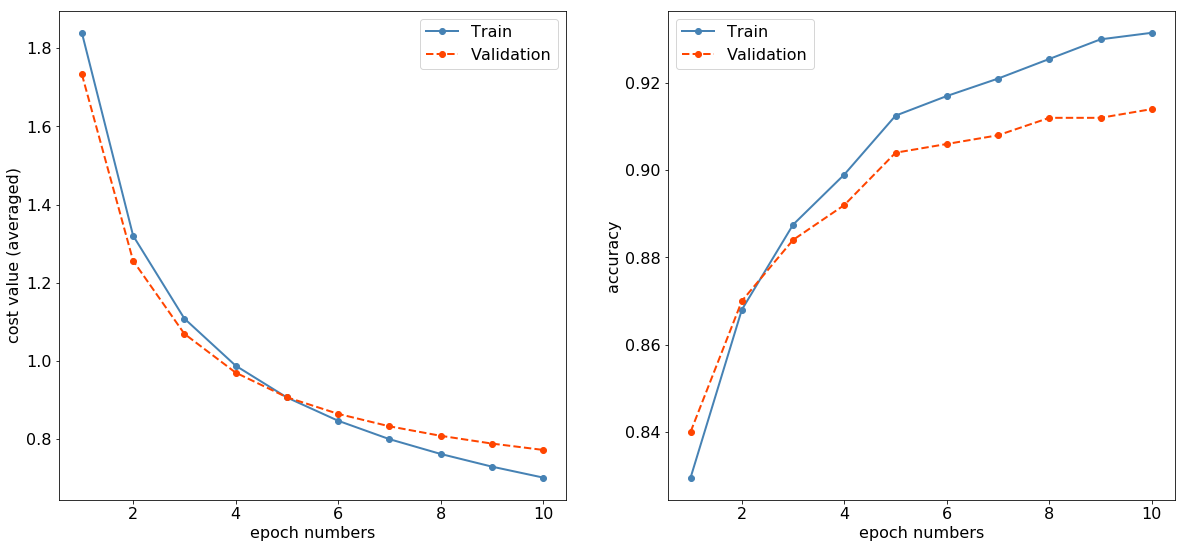

In [13]:
# 実際に実行
scratch_2d_cnn = Scratch2dCNNClassifier(
    FN=5, C=1, FS=5, S=1, P=0, PH=2, PW=2, PS=2, PP=0, 
    n_nodes1=400, n_nodes2=200, n_epochs=10, 
    learning_method="AdaGrad", alpha=2e-2, batch_size=20, 
    sigma="He", activation="ReLU", random_seed=0, verbose=True)

scratch_2d_cnn.fit(X_train[:2000, :, :, :], y_train[:2000], X_val[:500, :, :, :], y_val[:500])

## 6. LeNet（アドバンス課題）
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的。

現在では実用的に使われることはないが、歴史的に重要なのは1998年のLeNetである。この構造を再現して動かしてみる。

[Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf "Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11):2278–2324, 1998.")

サブサンプリングとは現在のプーリングに相当するもの。現代風に以下のように作ってみる。活性化関数も当時はシグモイド関数だが、ReLUとする。

- 畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1
- ReLU
- 最大プーリング
- 平滑化
- 全結合層　出力ノード数120
- ReLU
- 全結合層　出力ノード数84
- ReLU
- 全結合層　出力ノード数10
- ソフトマックス関数

In [14]:
class ScratchLeNet:
    """
    大枠で7層のCNN分類器
    ----------
    - 畳み込み隠れ層1
    - 最大プーリング層1
    - 畳み込み隠れ層2
    - 最大プーリング層2
    - 全結合隠れ層1
    - 全結合隠れ層2
    - 全結合出力層
    
    生成インスタンス一覧 (Forward昇順)
    ----------
    - Conv2dLayer
    - Activator
    - MaxPool2dLayer
    - Conv2dLayer
    - Activator
    - MaxPool2dLayer
    - Flatten
    - FullConnLayer
    - Activator
    - FullConnLayer
    - Activator
    - FullConnLayer
    - Softmax    

    Parameters
    ----------
    FN1 (Filter Number) : int
        畳み込み隠れ層1の出力チャンネル数（フィルターの個数）
    C1(Channels) : int
        畳み込み隠れ層1の入力チャンネル数
    FS1(Filter Size) : int
        畳み込み隠れ層1のフィルターの一辺の要素数 (長さ)
    S1(Stride) : int
        畳み込み隠れ層1のストライド数
    P1(Padding) : int
        畳み込み隠れ層1のパディング数
    PH1(Pooling Height) : int
        プーリング層1のプーリング適用領域の高さ
    PW1(Pooling Width) : int
        プーリング層1のプーリング適用領域の幅
    PS1(Pooling Stride) : int
        プーリング層1のプーリング適用領域のストライド数
    PP1(Pooling Padding) : int
        プーリング層1のプーリング適用領域のパディング数
    FN2 (Filter Number) : int
        畳み込み隠れ層2の出力チャンネル数（フィルターの個数）
    FS2(Filter Size) : int
        畳み込み隠れ層2のフィルターの一辺の要素数 (長さ)
    S2(Stride) : int
        畳み込み隠れ層2のストライド数
    P2(Padding) : int
        畳み込み隠れ層2のパディング数
    PH2(Pooling Height) : int
        プーリング層2のプーリング適用領域の高さ
    PW2(Pooling Width) : int
        プーリング層2のプーリング適用領域の幅
    PS2(Pooling Stride) : int
        プーリング層2のプーリング適用領域のストライド数
    PP2(Pooling Padding) : int
        プーリング層2のプーリング適用領域のパディング数
    n_nodes1 : int (default : 400)
        全結合隠れ層1のノード数
    n_nodes2 : int (default : 200)
        全結合隠れ層2のノード数
    n_epochs : int (default : 10)
        エポック回数
    learning_method : str (default : "SGD")
        学習の際の最適化手法("SGD", "AdaGrad"から選択)
    alpha : float (default : 0.01)
        学習率
    batch_size : int (default : 10)
        ミニバッチサイズ
    sigma : str or float (default : 0.01)
        各層の重み係数の初期値の標準偏差("Xavier", "He"から選択または値を直接入力)
    activation : str (default : "tanh")
        活性化関数 ("sigmoid", "tanh", ReLU"のいずれかを選択)
    random_seed : int (default : None)
        各層の重み係数の初期化および各エポック毎のデータシャッフル用の擬似乱数シード
    verbose : bool (default : True)
        学習過程を出力しない場合はFalseを設定

    Attributes
    ----------
    self.train_cost_ : list
        1エポック毎の訓練データのコスト関数値（交差エントロピー誤差）
    self.val_cost_ : list
        1エポック毎の検証データのコスト関数値（交差エントロピー誤差）
    self.train_accuracy_ : list
        1エポック毎の訓練データの正解率
    self.val_accuracy_ : list
        1エポック毎の検証データの正解率
    
    """
    def __init__(self, 
                 FN1=30, C1=1, FS1=5, S1=1, P1=0, PH1=2, PW1=2, PS1=2, PP1=0, 
                 FN2=30, FS2=5, S2=1, P2=0, PH2=2, PW2=2, PS2=2, PP2=0, 
                 n_nodes1=400, n_nodes2=200, n_epochs=10, 
                 learning_method="SGD", alpha=0.01, batch_size=10, 
                 sigma=0.01, activation="tanh", random_seed=None, verbose=True):
        # 畳み込み隠れ層1、プーリング層1
        self.FN1 = FN1
        self.C1 = C1
        self.FS1 = FS1
        self.S1 = S1
        self.P1 = P1
        self.PH1 = PH1
        self.PW1 = PW1
        self.PS1 = PS1
        self.PP1 = PP1
        # 畳み込み隠れ層2、プーリング層2
        self.FN2 = FN2
        self.C2 = FN1 # 畳み込み隠れ層2の入力チャンネル数は畳み込み隠れ層1の出力チャンネル数
        self.FS2 = FS2
        self.S2 = S2
        self.P2 = P2
        self.PH2 = PH2
        self.PW2 = PW2
        self.PS2 = PS2
        self.PP2 = PP2
        # 全結合層および全般
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_epochs = n_epochs
        self.learning_method = learning_method
        self.alpha = alpha
        self.batch_size = batch_size
        self.sigma = sigma
        self.activation = activation
        self.random_seed = random_seed # バッチ学習用
        self.random = np.random.RandomState(random_seed) # 重み初期化、各epoch毎のデータシャッフル用
        self.verbose = verbose
    
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        CNN分類器を学習する。

        Parameters
        ----------
        X_train : 次の形のndarray, shape (n_samples, channels, image_height, image_width)
            学習用データの特徴量
        y_train : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, channels, image_height, image_width)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        # コスト関数値、正解率の空リストを生成
        self.train_cost_ = []
        self.val_cost_ = []
        self.train_accuracy_ = []
        self.val_accuracy_ = []
        
        # 出力層のノード数と最適化手法のインスタンスを生成
        n_output = np.unique(y_train).shape[0]
        optimizer = LearningMethod(self.learning_method, self.alpha)
        
        # インスタンス生成に必要な入力画像特徴量数(n_features1, n_features2)を事前に計算
        image_size1 = X_train.shape[2] # 訓練データ画像のサイズ(高さ)、
        n_features1 = (image_size1**2) * self.C1 # 畳み込み隠れ層1の入力画像特徴量数
        OH = self._conv_func(image_size1, self.P1, self.FS1, self.S1) #  畳み込み隠れ層1の出力データの高さ
        image_size2 = int(1 + (OH - self.PH1) / self.PS1) # プーリング層1の出力データの高さ
        n_features2 = (image_size2**2) * self.C2 # 畳み込み隠れ層2の入力画像特徴量数
        
        # 畳み込み隠れ層1のインスタンスを生成
        self.layer_conv1 = Conv2dLayer(
            self.FN1, self.C1, self.FS1, self.sigma, n_features1, optimizer, self.S1, self.P1)
        
        # プーリング隠れ層1のインスタンスを生成
        self.layer_pool1 = MaxPool2dLayer(PH=self.PH1, PW=self.PW1, PS=self.PS1, PP=self.PP1)
        
        # 畳み込み隠れ層2のインスタンスを生成
        self.layer_conv2 = Conv2dLayer(
            self.FN2, self.C2, self.FS2, self.sigma, n_features2, optimizer, self.S2, self.P2)
        
        # プーリング隠れ層2のインスタンスを生成
        self.layer_pool2 = MaxPool2dLayer(PH=self.PH2, PW=self.PW2, PS=self.PS2, PP=self.PP2)
        
        # 全結合層に渡すn_pool_outを計算
        n_conv_output = (image_size2 - self.FS2 + 2 * self.P2) / self.S2 + 1
        n_pool_output = int(self.FN2 * (n_conv_output / 2) * (n_conv_output / 2))
        
        # 平滑化層のインスタンスを生成
        self.layer_flatten = Flatten()
        
        # 全結合層のインスタンスを作成
        self.layer1 = FullConnLayer(n_pool_output, self.n_nodes1, 
                                    SimpleInitializer(self.sigma, n_pool_output), optimizer)
        self.layer2 = FullConnLayer(self.n_nodes1, self.n_nodes2, 
                                    SimpleInitializer(self.sigma, self.n_nodes1), optimizer)
        self.layer_out = FullConnLayer(self.n_nodes2, n_output, 
                                       SimpleInitializer(self.sigma, self.n_nodes2), optimizer)
        
        # 活性化関数のインスタンスを作成
        self.activator_conv1 = Activator(self.activation)
        self.activator_conv2 = Activator(self.activation)
        self.activator1 = Activator(self.activation)
        self.activator2 = Activator(self.activation)
        self.activator_out = Softmax()
        
        # yラベルをOneHotEncoding
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_onehot = enc.fit_transform(y_train[:, np.newaxis])
        y_val_onehot = enc.transform(y_val[:, np.newaxis])
        
        # 学習の進捗バーを設定
        pbar = pyprind.ProgBar(self.n_epochs * (np.ceil(X_train.shape[0] / self.batch_size).astype(np.int)))
        
        # エポック毎に学習を繰り返す
        for i in range(self.n_epochs):
            get_mini_batch = GetMiniBatch(X_train, y_train_onehot, 
                                          batch_size=self.batch_size, seed=self.random_seed)
            
            # 1エポック毎にバッチデータ生成して学習
            for X_train_batch, y_train_batch in get_mini_batch:
                
                # Forward propagation
                z_out, a_out = self._forward(X_train_batch)
                
                # Backward propagation
                # grad_z_outは交差エントロピー誤差とソフトマックスを合わせている
                grad_z_out = self.activator_out.backward(a_out, y_train_batch)
                grad_a_n2 = self.layer_out.backward(grad_z_out)
                grad_z_n2 = self.activator2.backward(grad_a_n2)
                grad_a_n1 = self.layer2.backward(grad_z_n2)
                grad_z_n1 = self.activator1.backward(grad_a_n1)
                grad_a_n0 = self.layer1.backward(grad_z_n1)
                grad_z_flatten = self.layer_flatten.backward(grad_a_n0)
                grad_z_pool2 = self.layer_pool2.backward(grad_z_flatten)
                grad_z_conv2 = self.activator_conv2.backward(grad_z_pool2)
                grad_a_conv2 = self.layer_conv2.backward(grad_z_conv2)
                grad_z_pool1 = self.layer_pool1.backward(grad_a_conv2)
                grad_z_conv1 = self.activator_conv1.backward(grad_z_pool1)
                # grad_a_conv0は使用しないが、重み更新のためbackward実行
                grad_a_conv0 = self.layer_conv1.backward(grad_z_conv1)
                
                # 進捗バーを更新
                pbar.update()
            
            # 1エポック毎に訓練データのコスト関数値、正解率を記録
            z_out, a_out = self._forward(X_train)
            # コスト関数値
            value1 = y_train_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
            value2 = (1. - y_train_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
            train_cost = -np.sum(value1 + value2)
            self.train_cost_.append(train_cost)
            # 正解率
            y_train_pred = self.predict(X_train)
            train_accuracy = (np.sum(y_train == y_train_pred).astype(np.float)) / y_train.shape[0]
            self.train_accuracy_.append(train_accuracy)
            
            # 検証データがあれば同様に記録
            if X_val is not None and y_val is not None:
                z_out, a_out = self._forward(X_val)
                # コスト関数値
                value1 = y_val_onehot * (np.log(a_out + 1e-07)) # ゼロ除算対策
                value2 = (1. - y_val_onehot) * np.log(1. - a_out + 1e-07) # ゼロ除算対策
                val_cost = -np.sum(value1 + value2)
                self.val_cost_.append(val_cost)
                # 正解率
                y_val_pred = self.predict(X_val)
                val_accuracy = (np.sum(y_val == y_val_pred).astype(np.float)) / y_val.shape[0]
                self.val_accuracy_.append(val_accuracy)
        
        # 各コスト関数値を平均値で割る
        self.train_cost_ /= (sum(self.train_cost_) / len(self.train_cost_))
        if len(self.val_cost_) > 0:
            self.val_cost_ /= (sum(self.val_cost_) / len(self.val_cost_))
        
        #verboseをTrueにした際は学習過程などを出力
        if self.verbose:
            plt.rcParams["font.size"] = 16
            fig, ax = plt.subplots(1, 2, figsize=(20,9))
            ax[0].plot(np.arange(1, len(self.train_cost_)+1), self.train_cost_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[0].set_xlabel("epoch numbers")
            ax[0].set_ylabel("cost value (averaged)")
            ax[1].plot(np.arange(1, len(self.train_accuracy_)+1), self.train_accuracy_, 
                       linewidth=2, linestyle="-", marker="o", color="steelblue", label="Train")
            ax[1].set_xlabel("epoch numbers")
            ax[1].set_ylabel("accuracy")
            # 検証データも学習したら可視化
            if len(self.val_cost_) > 0:
                ax[0].plot(np.arange(1, len(self.val_cost_)+1), self.val_cost_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
                ax[1].plot(np.arange(1, len(self.val_accuracy_)+1), self.val_accuracy_, 
                           linewidth=2, linestyle="--", marker="o", color="orangered", label="Validation")
            ax[0].legend()
            ax[1].legend()
            plt.show()
    
    def predict(self, X_test):
        """
        学習したCNN分類器を使い推定する。

        Parameters
        ----------
        X_test : 次の形のndarray, shape (n_samples, channels, image_height, image_width)
            テスト用データの特徴量

        Returns
        -------
        y_pred : 次の形のndarray, shape (n_samples, 1)
            予測ラベル
        
        """
        z_out, a_out = self._forward(X_test)
        return np.argmax(z_out, axis=1) # 出力層への入力値で最大のノード位置を出力
    
    def _forward(self, X):
        # Forward propagation
        z_conv1 = self.layer_conv1.forward(X)
        a_conv1 = self.activator_conv1.forward(z_conv1)
        a_pool1 = self.layer_pool1.forward(a_conv1)
        z_conv2 = self.layer_conv2.forward(a_pool1)
        a_conv2 = self.activator_conv2.forward(z_conv2)
        a_pool2 = self.layer_pool2.forward(a_conv2)
        a_flatten = self.layer_flatten.forward(a_pool2)
        z_n1 = self.layer1.forward(a_flatten)
        a_n1 = self.activator1.forward(z_n1)
        z_n2 = self.layer2.forward(a_n1)
        a_n2 = self.activator2.forward(z_n2)
        z_out = self.layer_out.forward(a_n2)
        a_out = self.activator_out.forward(z_out)
        return z_out, a_out
    
    def _conv_func(self, N, P, F, S):
        # 入力画像サイズ、パディング、フィルタサイズ、ストライドから出力サイズを計算
        return int(((N + 2 * P - F)/ S) + 1)



0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:05:58


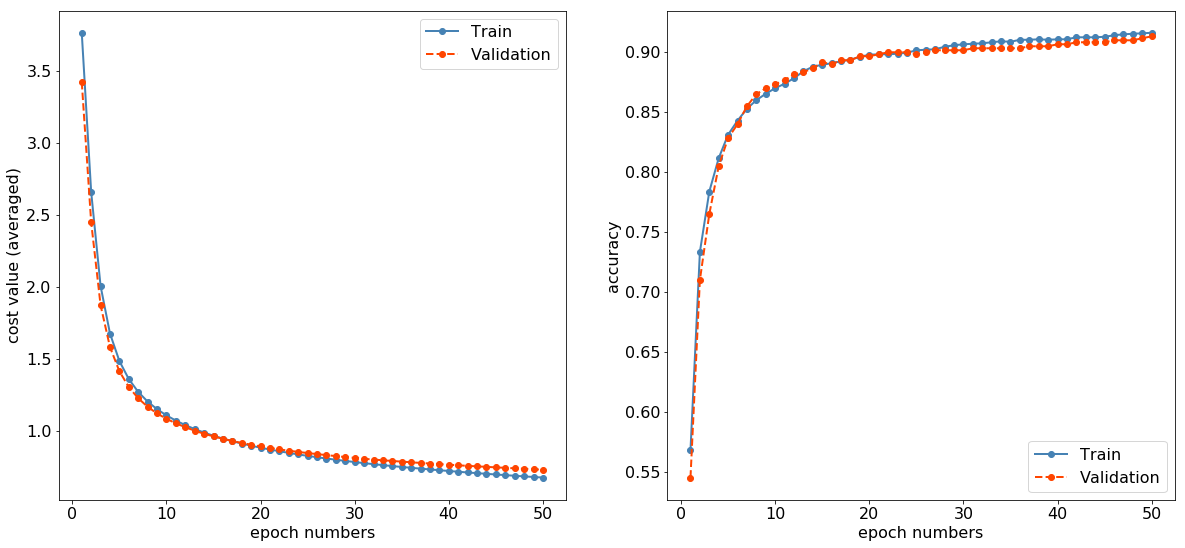

In [16]:
# メモリの関係上、データ数を減らして実行
scratch_lenet = ScratchLeNet(
    FN1=6, C1=1, FS1=5, S1=1, P1=0, PH1=2, PW1=2, PS1=2, PP1=0, 
    FN2=16, FS2=5, S2=1, P2=0, PH2=2, PW2=2, PS2=2, PP2=0, 
    n_nodes1=120, n_nodes2=84, n_epochs=50, 
    learning_method="AdaGrad", alpha=2e-2, batch_size=20, 
    sigma="He", activation="ReLU", random_seed=0, verbose=True)

scratch_lenet.fit(X_train[:2400, :, :, :], y_train[:2400], X_val[:600, :, :, :], y_val[:600])

## 7. 有名な画像認識モデルの調査（アドバンス課題）
CNNの代表的な構造としてはAlexNet(2012)、VGG16(2014)などがある。  
こういったものはフレームワークで既に用意されていることも多い。

どういったものがあるか簡単に調べてまとめる。名前だけでも見ておくと良い。

**参考**  
[Applications - Keras Documentation](https://keras.io/ja/applications/ "Applications - Keras Documentation")


## 8. 平均プーリングの作成（アドバンス課題）
平均プーリング層のクラスAveragePool2Dを作成する。

範囲内の最大値ではなく、平均値を出力とするプーリング層のこと。

画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われない。

## 9. 出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要がある。

また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってくる。  
フレームワークでは各層のパラメータ数を表示させることが可能だが、意味を理解していないと適切な調整が行えない。

以下の3つの畳み込み層の出力サイズとパラメータ数を計算する。  
パラメータ数についてはバイアス項も考える。

1.
- 入力サイズ : 144×144, 3チャンネル
- フィルタサイズ : 3×3, 6チャンネル
- ストライド : 1
- パディング : なし

2.
- 入力サイズ : 60×60, 24チャンネル
- フィルタサイズ : 3×3, 48チャンネル
- ストライド　: 1
- パディング : なし

3.
- 入力サイズ : 20×20, 10チャンネル
- フィルタサイズ: 3×3, 20チャンネル
- ストライド : 2
- パディング : なし

＊最後の例は丁度良く畳み込みをすることができない場合である。  
フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算する。  
端が欠けてしまうので、こういった設定は好ましくないという例である。

In [6]:
def conv_func(N_in, P, F, S):
    """
    入力画像サイズ、パディング、フィルタサイズ、ストライドから出力サイズとパラメータ数を計算

    Parameters
    ----------
    N_in : 次の形のndarray, shape (channels, image_height, image_width)
        入力画像サイズ
    P : int
        パディング
    F : 次の形のndarray, shape (filter_numbers, channels, filter_height, filter_width)
        フィルタサイズ
    S : int
        ストライド
    
    Prints
    -------
    N_out : 次の形のndarray, shape (filter_numbers, output_height, output_width)
        出力画像サイズ
    w_dim : 次の形のndarray, shape (filter_numbers, channels, filter_height, filter_width)
        パラメータwの次元ごとの要素数
    w_num : int
        パラメータwの総要素数
    b_num : int
        パラメータbの総要素数
    
    """
    print("出力サイズ：", ((N_in[1] + 2 * P - F)/ S) + 1) # 出力サイズを計算
    w_dim = np.array([F[0], N_in[0], F[2], F[3]])
    print("w(フィルター)の次元サイズ(FN, C, FH, FW)：", w_dim)
    print("wの総要素数：", w_dim[0] * w_dim[1] * w_dim[2] * w_dim[3])
    print("bの総要素数：", F[0])
    

# 1.のケース
N_in = np.array([3, 144, 144])
F = np.array([6, 3, 3, 3])
S = 1
P = 0
print("------1.のケース------")
conv_func(N_in, P, F, S)

# 2.のケース
N_in = np.array([24, 60, 60])
F = np.array([48, 24, 3, 3])
S = 1
P = 0
print("------2.のケース------")
conv_func(N_in, P, F, S)

# 3.のケース
N_in = np.array([10, 20, 20])
F = np.array([20, 10, 3, 3])
S = 2
P = 0
print("------3.のケース------")
conv_func(N_in, P, F, S)


------1.のケース------
出力サイズ： [139. 142. 142. 142.]
w(フィルター)の次元サイズ(FN, C, FH, FW)： [6 3 3 3]
wの総要素数： 162
bの総要素数： 6
------2.のケース------
出力サイズ： [13. 37. 58. 58.]
w(フィルター)の次元サイズ(FN, C, FH, FW)： [48 24  3  3]
wの総要素数： 10368
bの総要素数： 48
------3.のケース------
出力サイズ： [1.  6.  9.5 9.5]
w(フィルター)の次元サイズ(FN, C, FH, FW)： [20 10  3  3]
wの総要素数： 1800
bの総要素数： 20


出力サイズは、あえて浮動小数点で表示している。3.のケースでは、確かに出力サイズが整数で割り切れていない。

## 10. フィルタサイズに関する調査（アドバンス課題）
畳み込み層にはフィルタサイズというハイパーパラメータがあるが、2次元畳み込み層において現在では3×3と1×1の使用が大半。  
以下のそれぞれを調べたり、自分なりに考えて説明する。

- 7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由
- 高さや幅方向を持たない1×1のフィルタの効果